In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, activations
from keras.layers import Dense, Dropout, Flatten, Input, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from qkeras import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns

2022-11-10 22:37:02.601274: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 22:37:02.913052: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-10 22:37:02.921078: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-10 22:37:02.921107: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
train_df = pd.read_csv('train_1Dx.csv',nrows=1000000)
test_df = pd.read_csv('test_1Dx.csv',nrows=500000)

In [3]:
X_train = train_df.drop(columns=['x-midplane','cotAlpha']).values
X_test = test_df.drop(columns=['x-midplane','cotAlpha']).values

y_train = train_df['x-midplane'].values
y_test = test_df['x-midplane'].values

In [4]:
# scale so that it is between 0 and 1
def scale(X):
    width = np.max(X) - np.min(X)
    return ( X-np.min(X) ) / width

In [5]:
X_train = scale(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scale(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [6]:
def custom_loss(y, p):
    
    maxval = 1e9
    minval = 1e-9
    pi = 3.14159265359
    
    mu = tf.gather(params=p, indices=[0], axis=1)
    sigma = 0.1+tf.math.softplus(tf.gather(params=p, indices=[1], axis=1))
        
    likelihood = 1.0/tf.math.sqrt(2*pi)/sigma*tf.math.exp(-1*(y-mu)*(y-mu)/(2*sigma*sigma))
    likelihood = tf.clip_by_value(likelihood,minval,maxval)
    
    NLL = -1*tf.math.log(likelihood)
    
    return tf.keras.backend.sum(NLL,axis=1)

In [7]:
def CreateModel(shape):
    x = x_in = Input(shape)
    x = Dense(64, name="dense1")(x)
    x = Activation("relu", name="relu1")(x)
    #x = BatchNormalization()(x)
    x = Dense(2, name="dense2")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

model=CreateModel(X_train.shape[1:])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=custom_loss)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense1 (Dense)              (None, 64)                1408      
                                                                 
 relu1 (Activation)          (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense2 (Dense)              (None, 2)                 130       
                                                                 
Total params: 1,794
Trainable params: 1,666
Non-trainable params: 128
_________________________________________________________

2022-11-10 22:37:19.975685: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-10 22:37:19.975737: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-10 22:37:19.975782: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-jennetd): /proc/driver/nvidia/version does not exist
2022-11-10 22:37:19.976186: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
es = EarlyStopping(patience=10)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=500, 
                    batch_size=4096,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/400
196/196 [==============================] - 3s 9ms/step - loss: 18.1745 - val_loss: 18.3126
Epoch 2/400
196/196 [==============================] - 1s 7ms/step - loss: 13.6746 - val_loss: 13.5003
Epoch 3/400
196/196 [==============================] - 1s 7ms/step - loss: 10.0311 - val_loss: 8.6781
Epoch 4/400
196/196 [==============================] - 1s 7ms/step - loss: 8.3342 - val_loss: 7.1788
Epoch 5/400
196/196 [==============================] - 1s 7ms/step - loss: 7.1274 - val_loss: 6.2721
Epoch 6/400
196/196 [==============================] - 1s 7ms/step - loss: 6.1611 - val_loss: 5.5958
Epoch 7/400
196/196 [==============================] - 1s 7ms/step - loss: 5.3885 - val_loss: 5.0871
Epoch 8/400
196/196 [==============================] - 1s 7ms/step - loss: 4.9747 - val_loss: 4.8920
Epoch 9/400
196/196 [==============================] - 1s 7ms/step - loss: 4.8149 - val_loss: 4.7668
Epoch 10/400
196/196 [==============================] - 1s 7ms/step - loss: 4.7113 - v

/tmp/ipykernel_226544/3321773974.py:10: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


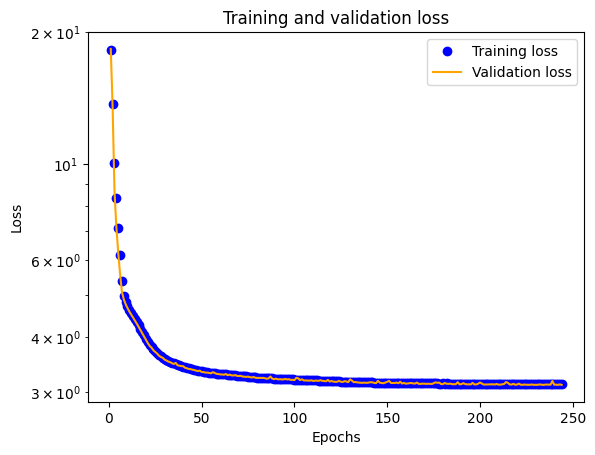

In [9]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('Log')
plt.legend()
plt.show()

In [10]:
model.save('models_1Dx/gauss.keras')

In [11]:
p_test = model.predict(X_test)
df = pd.DataFrame(p_test,columns=['mu','sigma'])
df['sigma'] = 0.1 + tf.math.softplus(df['sigma'])
df['xtrue'] = y_test
df.to_csv("test_1DxGauss.csv",header=False,index=False)


15625/15625 [==============================] - 20s 1ms/step


In [12]:
len(df)

500000

In [13]:
residuals = y_test - p_test[:,0]
print(np.mean(residuals),np.std(residuals))

-0.3597460328760197 6.460238508363173


In [14]:
uncertainty= 0.1 + tf.math.softplus(p_test[:,1])
print(np.mean(uncertainty),np.std(uncertainty))

5.641157 2.1351473


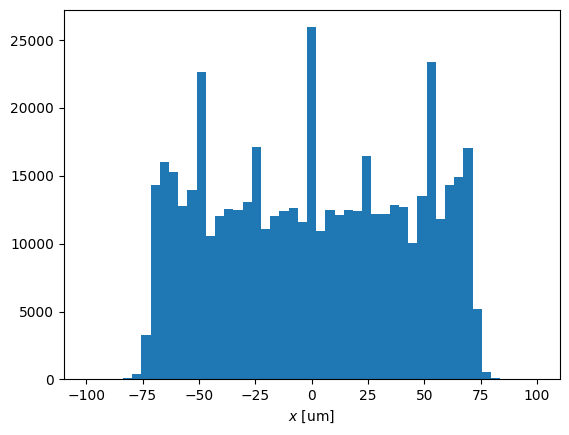

In [15]:
plt.hist(p_test[:,0],bins=np.linspace(-100,100,50))
#plt.yscale('Log')
plt.xlabel(r'$x$ [um]')
plt.show()

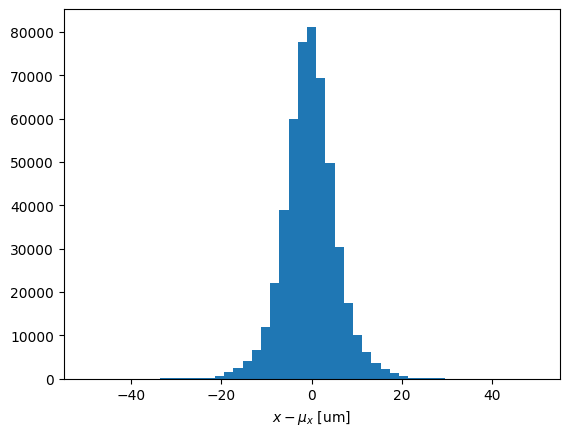

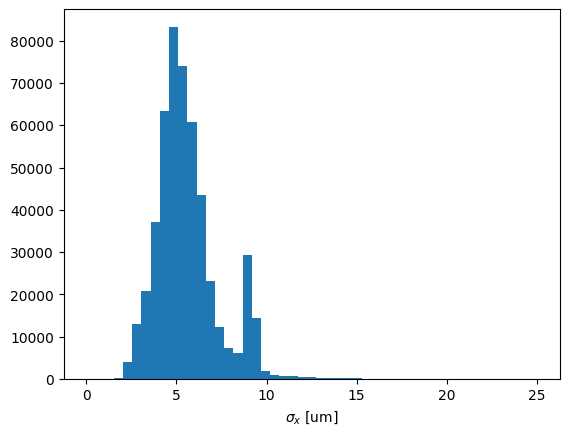

In [16]:
plt.hist(residuals,bins=np.linspace(-50,50,50))
#plt.yscale('Log')
plt.xlabel(r'$x-\mu_x$ [um]')
plt.show()

plt.hist(uncertainty,bins=np.linspace(0,25,50));
#plt.yscale('Log')
plt.xlabel(r'$\sigma_x$ [um]')
plt.show()

Text(0, 0.5, '$x-\\mu_x$ [um]')

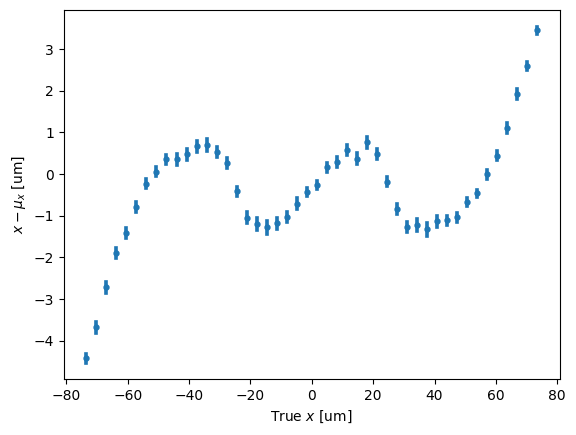

In [17]:
x = sns.regplot(x=df['xtrue'], y=df['xtrue']-df['mu'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.')
plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$x-\mu_x$ [um]')

Text(0, 0.5, '$\\sigma_x$ [um]')

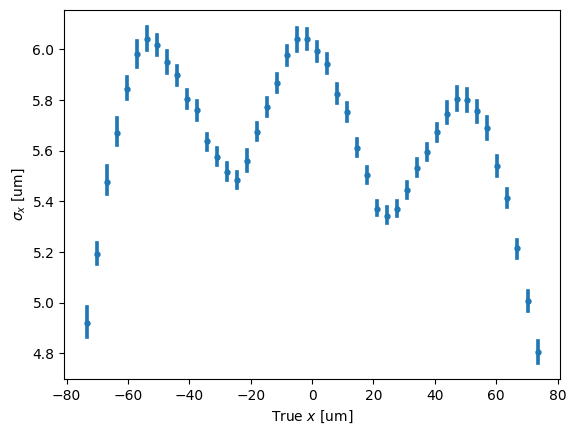

In [18]:
x = sns.regplot(x=df['xtrue'], y=df['sigma'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.')
plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$\sigma_x$ [um]')

In [19]:
pulls = residuals/p_test[:,1]

Text(0.5, 0, 'pull')

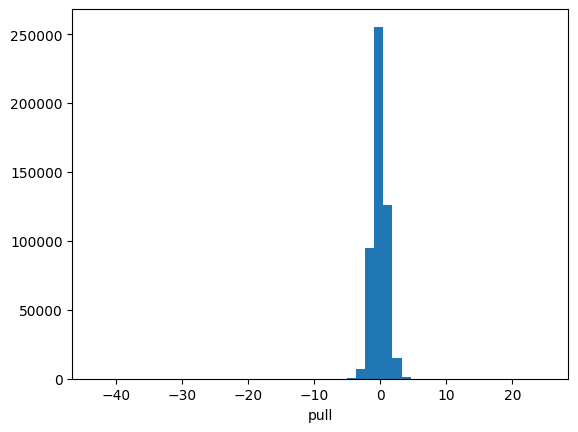

In [20]:
plt.hist(pulls,bins=50);
plt.xlabel('pull')

In [21]:
print(np.mean(pulls),np.std(pulls))

-0.07971068786600513 1.059034729413733


In [22]:
model.layers

In [23]:
max(np.array(model.layers[1].get_weights()).flatten()[0].flatten())

/tmp/ipykernel_226544/2940326780.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  max(np.array(model.layers[1].get_weights()).flatten()[0].flatten())


3.392645

In [24]:
np.max(np.array(model.layers[3].get_weights()).flatten())

6.2569876

Text(0.5, 0, 'true x [um]')

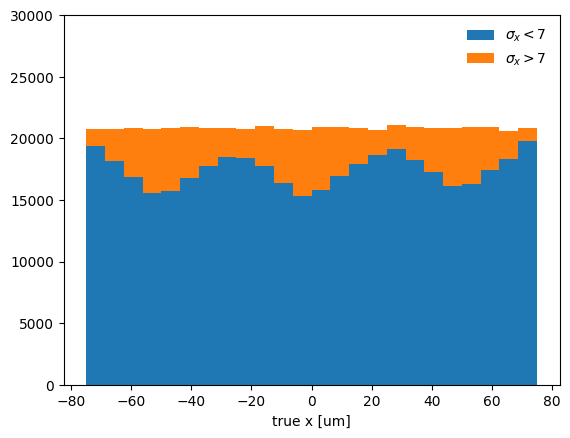

In [25]:
plt.hist([df[df['sigma']<7]['xtrue'],df[df['sigma']>7]['xtrue']],bins=np.linspace(-75,75,25),stacked=True,label=['$\sigma_x<7$','$\sigma_x>7$']);
plt.ylim(0,30000)
plt.legend(frameon=False)
plt.xlabel('true x [um]')